In [1]:
import os
from rosemary import jpt_setup; jpt_setup()

import matplotlib.pyplot as plt


from transformers.trainer_utils import get_last_checkpoint

import re
from llm.submit import (
    multiline_to_singleline,
    submit_job_ccc,
    submit_job_aimos,
    submit_job,
        get_run_statistics)
import pandas as pd
pd.set_option('display.max_colwidth', None)

import numpy as np
import json
import tempfile
import subprocess
import shlex
import datetime
import itertools
import glob

import base64
string_to_alphanumeric = lambda s: base64.urlsafe_b64encode(s.encode('utf-8')).decode('utf-8')
alphanumeric_to_string = lambda a: base64.urlsafe_b64decode(a).decode('utf-8')

from llm.submit import shell_scripts_template_slurm, shell_scripts_template_lsf, get_host_info, move_lsf_job_summary_to_save_dir
from note_pruning_analysis import open_instruct_dir

info = get_host_info()
arch, cluster = info['arch'], info['cluster']
print(info)

os.environ['TORCHELASTIC_ERROR_FILE'] = os.path.join(os.getcwd(), 'torchelastic_error_file') 

## jobs submitted in notebook inherits env variables.
cache_dir = '../../../../mitibm2023/cache'
os.environ['WANDB_DIR'] = cache_dir
os.makedirs(os.environ['WANDB_DIR'], exist_ok=True)
os.environ['WANDB_MODE'] = 'offline'
os.environ['WANDB_PROJECT'] = 'mitibm'
##
##

shell_scripts_template = shell_scripts_template_slurm \
    if arch == 'ppc64le' else shell_scripts_template_lsf

/gpfs/u/scratch/PTFM/PTFMqngp/github/rosemary/src/rosemary/__init__.py:25: UserWarning: Install `torch` for functionalities dependent on torch
  warn(f'Install `torch` for functionalities dependent on torch')


{'arch': 'ppc64le', 'cluster': 'dcs'}


# DPO

In [4]:
from llm.submit import shell_scripts_template_slurm
debug = False
if debug:
    os.environ['TORCH_CPP_LOG_LEVEL'] = 'INFO'
    os.environ['NCCL_DEBUG'] = 'INFO'
else:
    os.environ['TORCH_CPP_LOG_LEVEL'] = 'WARNING'
    os.environ['NCCL_DEBUG'] = ''
num_cpus = 144 if arch == 'ppc64le' else 32
cpu_mem =  650 if arch == 'ppc64le' else 64

preprocessing_num_workers = 32
report_to = 'wandb'
mixed_precision = 'bf16' if arch == 'x86_64' else 'fp16'
torch_dtype = 'bfloat16' if arch=='x86_64' else 'float32'
gradient_checkpointing = True
use_fast_tokenizer = True
hf_models_dir = 'results/baselines/'
resume_from_checkpoint = True # resume from latest checkpoint if exists, otherwise train from scratch
num_train_epochs = 2
checkpointing_steps = 300 # (50_000 / 32) * 2 / 6 ~= 500 (data size of 50k, bsz=32, ep=2, total save 6 times at most)
max_train_steps = None
subsample_inds_file_list = [None]
dataloader_sampler = 'RandomSampler'
overwrite_cache = True


# #####
# job_name = 'dpo1'

# # model_name_or_path = hf_models_dir+'huggyllama/llama-7b'; abbr_model_name = 'llama-7b'; max_seq_length = 2048
# model_name_or_path = hf_models_dir+'EleutherAI/pythia-410m-deduped'; max_seq_length = 2048; abbr_model_name = 'pythia-410m'
# # model_name_or_path = 'results/oi2/llama-7b_sharegptv2_ep=2'; max_seq_length = 2048; abbr_model_name = 'llama-7b+sharegptv2ep2'

# train_file = 'data/processed/ultrafeedback/ultrafeedback_data.jsonl'; dataset = 'ultrafeedback'
# #####


#####
model_name_or_path = 'results/oi2/llama-7b_sharegptv2_ep=2'; max_seq_length = 2048; abbr_model_name = 'llama-7b+sharegptv2ep2'
train_file = 'data/processed/ultrafeedback/ultrafeedback_data.jsonl'; dataset = 'ultrafeedback'


# M = 60_000; pacing_fn_list = [f'prune_size={M}_ep=3']; subset_size = 20_000
# M = 50_000; pacing_fn_list = [f'prune_size={M}_ep=5']; subset_size = 10_000
# M = 20_000; pacing_fn_list = [f'prune_size={M}_ep=4']; subset_size = 5_000
# M = 10_000; pacing_fn_list = [f'prune_size={M}_ep=10']; subset_size = 1_000
pacing_fn_list = [f'prune_size={M}_ep={ep}' for M, ep in [
    (10_000, 10),
#     (30_000, 3),
]]

gen_output_md = 'llama7br512p4096'
# gen_output_md = 'llama7b+sharegptv2ep2+r512p4096'
# gen_output_model_name = 'all-mpnet-base-v2'

scoring_fn_list = []
scoring_fn_list += ['random_s=0']
# scoring_fn_list += ['random_s=1']
scoring_fn_list += [ 
    f'dppmap_k=vmf_gamma=1_kmd={gen_output_md}_kemb=grad+rp+loraB',
    f'dppmap_k=rbf_gamma=1e-3_kmd={gen_output_md}_kemb=text+embedding',
#     f'dppmap_k=rbf_gamma=1_kmd=mpnet_kemb=text+embedding',
]
scoring_fn_and_pacing_fn = list(itertools.product(scoring_fn_list, pacing_fn_list))


job_name = f'dpo2_{dataset}:{abbr_model_name}'
    

#####


####



#####
test_run = 1
test_run = bool(test_run)

nodes = 5; num_gpus = 6; gpu_type = 'v100'; job_duration = 6
# nodes = 5; num_gpus = 6; gpu_type = 'v100'; job_duration = 12
# nodes = 2; num_gpus = 1; gpu_type = 'v100'; job_duration = 6; cpu_mem = 100; num_cpus = 32; max_train_steps = 5; checkpointing_steps = 2; report_to = 'tensorboard'

    
#####


if scoring_fn_and_pacing_fn is not None: # pruning runs. 
    print('Set up data pruning runs. epochs=1, sampler=SequentialSampler, and `subsampe_inds_file`')
    num_train_epochs = 1 # offload handling of epochs to `generate_curriculum`
    dataloader_sampler = 'SequentialSampler'
    subsample_inds_file_list = []
    for scoring_fn, pacing_fn in scoring_fn_and_pacing_fn:
        from note_pruning import get_final_model_name
        from note_pruning_analysis import get_full_model_name, curriculum_dir
        gen_output_model_name = get_final_model_name(get_full_model_name(gen_output_md), scoring_fn)
        print(json.dumps({'scoring_fn': scoring_fn, 'gen_output_md': gen_output_md, 'gen_output_model_name': gen_output_model_name}, indent=4))
        p = os.path.join(curriculum_dir, gen_output_model_name, dataset, scoring_fn, 'inds_'+pacing_fn+'.pkl')
        if not os.path.isfile(p):
            raise ValueError(f'path={p} does not exists for {scoring_fn}')
        subsample_inds_file_list.append(p)

if not os.path.isfile(train_file):
    print(f'train_file={train_file} does not exists')

use_deepspeed = True
deepspeed_config_file = 'ds_configs/stage3_no_offloading_accelerate.conf'

per_device_train_batch_size = 1; total_batch_size = 32
gradient_accumulation_steps = round(total_batch_size/(num_gpus*nodes)/per_device_train_batch_size)
effective_batch_size = per_device_train_batch_size*nodes*num_gpus*gradient_accumulation_steps

print(f"Training {model_name_or_path} "
      f"using {num_gpus} GPUs, "
      f"{per_device_train_batch_size} batch size per GPU, "
      f"{gradient_accumulation_steps} gradient accumulation steps, "
      f"{effective_batch_size} effective batch size.")

# reference: https://gist.github.com/pacman100/1cb1f17b2f1b3139a63b764263e70b25
launcher = f"""accelerate launch \
    --mixed_precision {mixed_precision} \
    --num_machines {nodes} \
    --num_processes {num_gpus*nodes} \
    {'--use_deepspeed' if use_deepspeed else ''} \
    {'--deepspeed_config_file '+deepspeed_config_file if use_deepspeed else ''} \
    {'--main_process_ip $master_addr' if use_deepspeed else ''} \
    {'--main_process_port $master_port' if use_deepspeed else ''} \
    {'--machine_rank $SLURM_PROCID' if use_deepspeed else ''} \
    {'--rdzv_backend c10d' if use_deepspeed and nodes>1 else ''} \
    {'--deepspeed_multinode_launcher standard' if use_deepspeed and nodes>1 else ''} \
"""

cmds = []


options_list = itertools.product(
    subsample_inds_file_list,
)

output_dirname_list = []
for (subsample_inds_file,) in options_list:

    output_dirname = f"{abbr_model_name}_{dataset}"
    if any(job_name == y for y in ['dpo1']):
        output_dirname += f'_ep={num_train_epochs}'
    if test_run:
        output_dirname = 'jpt_'+output_dirname

    if subsample_inds_file:
        assert(num_train_epochs==1)
        def subsample_inds_file_abbr_fn(x):
            s = os.path.basename(x).split('.pkl')[0]
            if s.startswith('inds_'):
                scoring_fn = os.path.basename(os.path.dirname(x)).replace('_', ':')
                pacing_fn = s.split('inds_')[-1].replace('_', ':')
                s = f'score={scoring_fn}_pace={pacing_fn}'
            return s
        subsample_inds_file_abbr = subsample_inds_file_abbr_fn(subsample_inds_file)
        if subsample_inds_file_abbr:
            output_dirname += f'_{subsample_inds_file_abbr}'

    if subsample_inds_file is not None:
        assert(dataloader_sampler=='SequentialSampler')
        assert(num_train_epochs==1)
    else:
        assert(dataloader_sampler=='RandomSampler')

    output_dir = os.path.join('results', job_name, output_dirname)
    os.makedirs(os.path.join('results', job_name), exist_ok=True)
    wandb_run_name = output_dir.replace('results/', '')


    cmd = f"""
    {f'cd .. && CUDA_VISIBLE_DEVICES={os.environ["CUDA_VISIBLE_DEVICES"]} ' if test_run else ''}{launcher}
        open_instruct/dpo_tune.py \
        --model_name_or_path {model_name_or_path} \
        --tokenizer_name {model_name_or_path} \
        {'--use_slow_tokenizer' if not  use_fast_tokenizer else ''} \
        {'--gradient_checkpointing' if gradient_checkpointing  else ''} \
        --train_file {train_file} \
        --max_seq_length {max_seq_length} \
        {'--subsample_inds_file '+subsample_inds_file if subsample_inds_file else ''} \
        --dataloader_sampler {dataloader_sampler} \
        --preprocessing_num_workers {preprocessing_num_workers} \
        --per_device_train_batch_size {per_device_train_batch_size} \
        --gradient_accumulation_steps {gradient_accumulation_steps} \
        --learning_rate 5e-7 \
        --lr_scheduler_type linear \
        --warmup_ratio 0.1 \
        --weight_decay 0. \
        --num_train_epochs {num_train_epochs} \
        --with_tracking \
        {'--report_to "'+str(report_to)+'"' if report_to else ''} \
        --checkpointing_steps {checkpointing_steps} \
        {'--max_train_steps '+str(max_train_steps) if max_train_steps else ''} \
        {'--resume_from_checkpoint' if resume_from_checkpoint else ''} \
        {'--low_cpu_mem_usage' if not use_deepspeed else ''} \
        {'--overwrite_cache' if overwrite_cache else ''} \
        --logging_steps 1 \
        --output_dir {output_dir}
    """
    # if test_run:
    #     print('\n'+' \\\n\t'.join([x.strip() for x in re.split(r'\s{3,}', cmd)]))

    cmd = multiline_to_singleline(cmd)
    cmds.append(cmd)

    if test_run:
        print(cmd)

    shell_scripts = shell_scripts_template.format(
        conda_env='open-instruct',
        cwd=os.path.dirname(os.getcwd()),
        cmd=cmd,
        log_dir=os.getcwd(),
        save_dir=output_dir
    )
    if arch == 'x86_64': # ccc
        shell_scripts = re.sub('~/.profile', '/dccstor/data-pruning/.profile', shell_scripts)
    out = submit_job(
        shell_scripts, 
        job_name=job_name, 
        nodes=nodes,
        num_cpus=num_cpus,
        cpu_mem=cpu_mem,
        num_gpus=num_gpus,
        gpu_type=gpu_type,
        test_run=test_run,
        job_duration=job_duration,
    )
    if not test_run:
        print(out)

Set up data pruning runs. epochs=1, sampler=SequentialSampler, and `subsampe_inds_file`
{
    "scoring_fn": "random_s=0",
    "gen_output_md": "llama7br512p4096",
    "gen_output_model_name": "llama-7b+lora:r=512:a=11585+proj=4096"
}
{
    "scoring_fn": "dppmap_k=vmf_gamma=1_kmd=llama7br512p4096_kemb=grad+rp+loraB",
    "gen_output_md": "llama7br512p4096",
    "gen_output_model_name": "llama-7b+lora:r=512:a=11585+proj=4096"
}
{
    "scoring_fn": "dppmap_k=rbf_gamma=1e-3_kmd=llama7br512p4096_kemb=text+embedding",
    "gen_output_md": "llama7br512p4096",
    "gen_output_model_name": "llama-7b+lora:r=512:a=11585+proj=4096"
}
Training results/oi2/llama-7b_sharegptv2_ep=2 using 6 GPUs, 1 batch size per GPU, 1 gradient accumulation steps, 30 effective batch size.

Submiting job with:
{
    "job_name": "dpo2_ultrafeedback:llama-7b+sharegptv2ep2",
    "nodes": 5,
    "num_cpus": 144,
    "cpu_mem": 650,
    "num_gpus": 6,
    "gpu_type": "v100",
    "test_run": false,
    "queue": "el8",
    "

In [90]:
with open('gen_cmds_dpo.sh', 'w') as f:
    s = 'set -e\nset -x\n'
    devices = os.environ['CUDA_VISIBLE_DEVICES'].split(',')[-1]
    s += '\n\n'.join([f"CUDA_VISIBLE_DEVICES={devices} "+x for x in cmds])
    f.write(s)

In [42]:
!bash gen_cmds_dpo.sh


+ CUDA_VISIBLE_DEVICES=5
+ cd ..
+ CUDA_VISIBLE_DEVICES=2,5
+ accelerate launch --mixed_precision fp16 --num_machines 1 --num_processes 2 --use_deepspeed --deepspeed_config_file ds_configs/stage3_no_offloading_accelerate.conf open_instruct/dpo_tune.py --model_name_or_path results/baselines/huggyllama/llama-7b --tokenizer_name results/baselines/huggyllama/llama-7b --gradient_checkpointing --train_file data/processed/ultrafeedback/ultrafeedback_data.jsonl --max_seq_length 2048 --preprocessing_num_workers 32 --per_device_train_batch_size 1 --gradient_accumulation_steps 16 --learning_rate 5e-7 --lr_scheduler_type linear --warmup_ratio 0.1 --weight_decay 0. --num_train_epochs 2 --with_tracking --report_to tensorboard --checkpointing_steps 500 --logging_steps 1 --output_dir results/dpo1/jpt_llama-7b_ultrafeedback
[2024-01-08 20:41:08,547] [INFO] [real_accelerator.py:158:get_accelerator] Setting ds_accelerator to cuda (auto detect)
The following values were not passed to `accelerate launch` a

You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 32001. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc
01/08/2024 20:42:20 - INFO - accelerate.accelerator - Updating DeepSpeed's gradient accumulation steps to 16 from 1.
[2024-01-08 20:42:20,382] [INFO] [logging.py:96:log_dist] [Rank 0] DeepSpeed info: version=0.10.1+23a11a39, git-hash=23a11a39, git-branch=master
01/08/2024 20:42:20 - INFO - torch.distributed.distributed_c10d - Added key: store_based_barrier_key:2 to store for rank: 0
01/08/2024 20:42:20 - INFO - torch.distributed.distributed_c10d - Added key: store_based_barrier_key:2 to store for rank: 1
01/08/2024 20:42:20 - INFO - torch.distri

ERROR:torch.distributed.elastic.multiprocessing.api:failed (exitcode: 1) local_rank: 0 (pid: 409110) of binary: /gpfs/u/scratch/PTFM/PTFMqngp/miniconda3/envs/open-instruct/bin/python3.10
Traceback (most recent call last):
  File "/gpfs/u/scratch/PTFM/PTFMqngp/miniconda3/envs/open-instruct/bin/accelerate", line 8, in <module>
    sys.exit(main())
  File "/gpfs/u/scratch/PTFM/PTFMqngp/miniconda3/envs/open-instruct/lib/python3.10/site-packages/accelerate/commands/accelerate_cli.py", line 45, in main
    args.func(args)
  File "/gpfs/u/scratch/PTFM/PTFMqngp/miniconda3/envs/open-instruct/lib/python3.10/site-packages/accelerate/commands/launch.py", line 964, in launch_command
    deepspeed_launcher(args)
  File "/gpfs/u/scratch/PTFM/PTFMqngp/miniconda3/envs/open-instruct/lib/python3.10/site-packages/accelerate/commands/launch.py", line 687, in deepspeed_launcher
    distrib_run.run(args)
  File "/gpfs/u/scratch/PTFM/PTFMqngp/miniconda3/envs/open-instruct/lib/python3.10/site-packages/torch/di

# Finetuning with openinstruct/finetune_trainer.py


In [15]:
add_hardwarespec_to_dirname = False
save_strategy = 'steps'
save_steps = 100
save_total_limit = 1
preprocessing_num_workers = 32
evaluation_strategy = 'no' # set do_eval=False
eval_steps = save_steps
report_to = 'tensorboard wandb'
suffix = None
lr_scheduler_type = 'linear'
warmup_ratio = 0.03
dataloader_sampler = None
hf_models_dir = 'results/baselines/'
subsample_inds_file_list = [None]
max_train_samples_list = [None]
num_train_epochs_list = [1]
scoring_fn_and_pacing_fn = None


########### sft baselines


job_name = 'oi2'; num_train_epochs_list = [2] 
# model_name_or_path = hf_models_dir+'mistralai/Mistral-7B-v0.1'; abbr_model_name = 'mistral-7b'; max_seq_length = 2048
model_name_or_path = hf_models_dir+'huggyllama/llama-7b'; abbr_model_name = 'llama-7b'; max_seq_length = 2048

# train_file = 'data/processed/sharegpt/sharegptv2_data.jsonl'; abbr_train_file = 'sharegptv2'
# train_file = 'data/processed/open_orca/open_orca_slim_data.jsonl'; abbr_train_file = 'openorcaslim'; max_train_samples_list=[100_000]
# train_file = 'data/processed/stanford_alpaca/stanford_alpaca_data.jsonl'; abbr_train_file = 'stanford_alpaca'; 
# train_file = 'data/processed/flan_v2/flan_v2_data.jsonl'; abbr_train_file = 'flan_v2';
# train_file = 'data/processed/oasst1/oasst1_data.jsonl'; abbr_train_file = 'oasst1';
# train_file = 'data/processed/dolly/dolly_data.jsonl'; abbr_train_file = 'dolly';
# train_file = 'data/processed/wizardlm/wizardlmv2_data.jsonl'; abbr_train_file = 'wizardlmv2';
# train_file = 'data/processed/tulu_v2/tulu_v2_data.jsonl'; abbr_train_file = 'tulu_v2'; max_train_samples_list=[100_000]
###########


# ############ pruning runs

# # model_name_or_path = hf_models_dir+'mistralai/Mistral-7B-v0.1'; abbr_model_name = 'mistral-7b'; max_seq_length = 2048; gen_output_md = 'mistral7br512p4096'
# model_name_or_path = hf_models_dir+'huggyllama/llama-7b'; abbr_model_name = 'llama-7b'; max_seq_length = 2048; gen_output_md = 'llama7br512p4096'

# # dataset = 'wizardlmv2'; train_file = 'data/processed/wizardlm/wizardlmv2_data.jsonl'; abbr_train_file = 'wizardlmv2';
# # dataset = 'dolly'; train_file = 'data/processed/dolly/dolly_data.jsonl'; abbr_train_file = 'dolly';
# # dataset = 'flan_v2'; train_file = 'data/processed/flan_v2/flan_v2_data.jsonl'; abbr_train_file = 'flan_v2';
# # dataset = 'oasst1'; train_file = 'data/processed/oasst1/oasst1_data.jsonl'; abbr_train_file = 'oasst1'; 
# # dataset = 'sharegptv2'; train_file = 'data/processed/sharegpt/sharegptv2_data.jsonl'; abbr_train_file = 'sharegptv2';
# # dataset = 'stanford_alpaca'; train_file = 'data/processed/stanford_alpaca/stanford_alpaca_data.jsonl'; abbr_train_file = 'stanford_alpaca';
# # dataset = 'ultrachat200kv2'; train_file = 'data/processed/ultrachat/ultrachat200kv2_train_data.jsonl'; abbr_train_file = 'ultrachat200kv2';
# # dataset = 'open_orca_slim'; train_file = 'data/processed/open_orca/open_orca_slim_data.jsonl'; abbr_train_file = 'openorcaslim'; 
# # dataset = 'tulu_v2'; train_file = 'data/processed/tulu_v2/tulu_v2_data.jsonl'; abbr_train_file = 'tulu_v2';

# # M = 80_000; pacing_fn_list = [f'prune_size={M}_ep=2']; subset_size = 40_000
# # M = 60_000; pacing_fn_list = [f'prune_size={M}_ep=3']; subset_size = 20_000
# # M = 50_000; pacing_fn_list = [f'prune_size={M}_ep=5']; subset_size = 10_000
# # M = 20_000; pacing_fn_list = [f'prune_size={M}_ep=4']; subset_size = 5_000
# M = 10_000; pacing_fn_list = [f'prune_size={M}_ep=10']; subset_size = 1_000


# scoring_fn_list = [
#     'random_s=0', 'random_s=1',
#     'log_prob_neg', 'el2n_agg=mean', 'grad_loraB_l2n',
#     'ifd_neg', 'log_pmi_neg',
#     'numtoks_input_neg', 'numtoks_output_neg', 'numtoks_total_neg',
#     f'dppmap_k=vmf_gamma=1_kmd=mpnet', #_kemb=text+embedding',
#     f'dppmap_k=rbf_gamma=1e-3_kmd=llama7br512p4096_kemb=text+embedding',
#     f'dppmap_k=vmf_gamma=1_kmd=llama7br512p4096_kemb=grad+rp+loraB',
# ]

# scoring_fn_list += [ # vary kernel embedding model 
# #     f'dppmap_k=vmf_gamma=auto{subset_size}_kmd={kmd}_kemb=grad+rp+loraB'
# #     for kmd in ['llama7br256p4096', 'llama7br512p4096', 'pythia1br512p4096']
# ]
# scoring_fn_and_pacing_fn = list(itertools.product(scoring_fn_list, pacing_fn_list))


# job_name = f'oi5_{dataset}:{abbr_model_name}'
# ############ 

    


#############

test_run = 1
test_run = bool(test_run)
debug_mode = test_run

if arch == 'x86_64':
#     nodes = 1; num_gpus = 1; gpu_type = 'a100_80gb'; job_duration = 6
    nodes = 1; num_gpus = 2; gpu_type = 'a100_80gb'; job_duration = 6
    num_cpus = int(128/8*num_gpus); cpu_mem = int(768/8*num_gpus)
    per_device_train_batch_size = 2
    gradient_checkpointing = True
    mixed_precision = 'bf16'; torch_dtype = 'bfloat16'; use_flash_attn = True
else:
    nodes = 5; num_gpus = 6; gpu_type = 'v100'; job_duration = 6
#     nodes = 5; num_gpus = 6; gpu_type = 'v100'; job_duration = 12
#     nodes = 5; num_gpus = 6; gpu_type = 'v100'; job_duration = 18
    num_cpus = int(128/6*num_gpus); cpu_mem = int(512/6*num_gpus)
    per_device_train_batch_size = 2
    gradient_checkpointing = True
    mixed_precision = 'fp16'; torch_dtype = 'float32'; use_flash_attn = False
    

if scoring_fn_and_pacing_fn is not None: # pruning runs. 
    print('Set up data pruning runs. epochs=1, sampler=SequentialSampler, and `subsampe_inds_file`')
    num_train_epochs_list = [1] # offload handling of epochs to `generate_curriculum`
    dataloader_sampler = 'SequentialSampler'
    subsample_inds_file_list = []
    for scoring_fn, pacing_fn in scoring_fn_and_pacing_fn:
        from note_pruning import get_final_model_name
        from note_pruning_analysis import get_full_model_name, curriculum_dir
        gen_output_model_name = get_final_model_name(get_full_model_name(gen_output_md), scoring_fn)
        print(json.dumps({'scoring_fn': scoring_fn, 'gen_output_md': gen_output_md, 'gen_output_model_name': gen_output_model_name}, indent=4))
        p = os.path.join(curriculum_dir, gen_output_model_name, dataset, scoring_fn, 'inds_'+pacing_fn+'.pkl')
        if not os.path.isfile(p):
            raise ValueError(f'path={p} does not exists for {scoring_fn}')
        subsample_inds_file_list.append(p)

overwrite_output_dir = True if test_run else False # always continue from ckpt if run from cluster.

total_batch_size = 128
gradient_accumulation_steps = round(total_batch_size/(num_gpus*nodes)/per_device_train_batch_size)
effective_batch_size = per_device_train_batch_size*nodes*num_gpus*gradient_accumulation_steps

optimizer = 'adamw_hf'

deepspeed = ''; fsdp = False if num_gpus == 1 else "full_shard auto_wrap" 
if 'gpt2' in abbr_model_name: fsdp_transformer_layer_cls_to_wrap = 'GPT2Block'
elif 'llama' in abbr_model_name: fsdp_transformer_layer_cls_to_wrap = 'LlamaDecoderLayer'
elif 'mpt' in abbr_model_name: fsdp_transformer_layer_cls_to_wrap = 'MPTBlock'
elif 'pythia' in abbr_model_name: fsdp_transformer_layer_cls_to_wrap = 'GPTNeoXLayer'        
elif 'mistral' in abbr_model_name: fsdp_transformer_layer_cls_to_wrap = 'MistralDecoderLayer'
else: raise ValueError('Not sure how to set `fsdp_transformer_layer_cls_to_wrap`')
    
# deepspeed = './ds_configs/ds_zero3_cpu_offload.json'; fsdp = False
# deepspeed = './ds_configs/ds_zero3.json'; fsdp = False
# deepspeed = './ds_configs/stage3_no_offloading.conf'; fsdp = False # error with loading... something wrong with the config.
# fsdp = False; deepspeed = False

if fsdp and deepspeed:
    raise ValueError('either fsdp or deepspeed, not both')

use_lora = False
lora_rank = 256 
lora_alpha = lora_rank 
lora_dropout = 0.05
if use_lora:
    abbr_model_name += f'+lora(r={lora_rank},a={lora_alpha})'
load_in_8bit = False

print(f"Training {model_name_or_path} "
      f"using {num_gpus} GPUs, "
      f"{per_device_train_batch_size} batch size per GPU, "
      f"{gradient_accumulation_steps} gradient accumulation steps, "
      f"Effective batch size {effective_batch_size}")


if nodes == 1:
    exe = 'python' if num_gpus==1 else \
        f"torchrun --nproc_per_node={num_gpus} --master_port=10002"
else:
    exe = f"torchrun --nnodes={nodes} --nproc_per_node={num_gpus} --rdzv-id=$SLURM_JOB_ID --rdzv-backend=c10d --rdzv-endpoint=$RDZV_ENDPOINT"

if test_run:
    exe = f"CUDA_VISIBLE_DEVICES={','.join(map(str, range(num_gpus)))} {exe}"
if test_run and debug_mode:
    exe = 'TORCH_CPP_LOG_LEVEL=INFO NCCL_DEBUG=INFO LOGLEVEL=INFO ' + exe
    error_file = os.path.join(open_instruct_dir, 'scripts', 'error_file')
    exe = f'TORCHELASTIC_ERROR_FILE={error_file} {exe}'

if not os.path.isfile(train_file):
    print(f'train_file={train_file} does not exists')

options_list = itertools.product(
    num_train_epochs_list,
    subsample_inds_file_list,
    max_train_samples_list,
)

cmds = []
output_dirname_list = []
for (num_train_epochs,
     subsample_inds_file,
     max_train_samples,) in options_list:

    output_dirname = f"{abbr_model_name}_{abbr_train_file}"
    if max_train_samples:
        output_dirname += f":{int(max_train_samples/1000)}k"
            
    if any(job_name == y for y in ['oi2']):
        output_dirname += f'_ep={num_train_epochs}'
        
    if subsample_inds_file:
        def subsample_inds_file_abbr_fn(x):
            s = os.path.basename(x).split('.pkl')[0]
            if s.startswith('inds_'):
                scoring_fn = os.path.basename(os.path.dirname(x)).replace('_', ':')
                pacing_fn = s.split('inds_')[-1].replace('_', ':')
                return f'score={scoring_fn}_pace={pacing_fn}'
            else:
                return s
        subsample_inds_file_abbr = subsample_inds_file_abbr_fn(subsample_inds_file)
        if subsample_inds_file_abbr:
            output_dirname += f'_{subsample_inds_file_abbr}'
            
    if test_run:
        output_dirname = 'jpt_'+output_dirname
            
    if add_hardwarespec_to_dirname:
        output_dirname += \
            ('_fsdp='+fsdp.split(' ')[0] if fsdp else '')+\
            ('_deepspeed='+os.path.basename(deepspeed).split('.')[0] if deepspeed else '')+\
            ('_gradckpt='+str(gradient_checkpointing) if gradient_checkpointing else '')+\
            '_mbsz='+str(per_device_train_batch_size)+\
            '_dtype='+torch_dtype+\
            ('_mp='+str(mixed_precision) if mixed_precision else '_mp=none')+\
            '_seqlen='+str(max_seq_length)+\
            '_nodes='+str(nodes)
    if suffix:
        output_dirname += suffix
    output_dir = os.path.join(open_instruct_dir, 'results', job_name, output_dirname)
    os.makedirs(os.path.join(open_instruct_dir, 'results', job_name), exist_ok=True)
    wandb_run_name = output_dir.replace('results/', '')
    

    cmd = f"""
    {'cd .. && ' if test_run else ''}{exe}
        open_instruct/finetune_trainer.py \
        --model_name_or_path={model_name_or_path} \
        --tokenizer_name={model_name_or_path} \
        {'--load_in_8bit' if load_in_8bit else ''} \
        --use_fast_tokenizer=True \
        --train_file={train_file} \
        --max_seq_length={max_seq_length} \
        {'--max_train_samples='+str(max_train_samples) if max_train_samples else ''} \
        {'--use_lora' if use_lora else ''}
        {'--lora_rank='+str(lora_rank) if use_lora else ''}
        {'--lora_alpha='+str(lora_alpha) if use_lora else ''}
        {'--lora_dropout='+str(lora_dropout) if use_lora else ''}
        --do_train \
        --preprocessing_num_workers={preprocessing_num_workers} \
        --per_device_train_batch_size={per_device_train_batch_size} \
        --gradient_accumulation_steps={gradient_accumulation_steps} \
        --learning_rate=2e-5 \
        --lr_scheduler_type={lr_scheduler_type} \
        --warmup_ratio={warmup_ratio} \
        --weight_decay=0. \
        --optim={optimizer} \
        --evaluation_strategy={evaluation_strategy} \
        {'--eval_steps='+str(eval_steps) if eval_steps else ''} \
        {'--report_to '+str(report_to) if report_to else ''} \
        --run_name {wandb_run_name} \
        --logging_strategy=steps \
        --logging_first_step \
        --logging_steps=1 \
        --save_strategy={save_strategy} \
        --save_steps={save_steps} \
        --save_total_limit={save_total_limit} \
        --num_train_epochs={num_train_epochs} \
        --ddp_timeout=7200 \
        {'--fsdp="'+fsdp+'"' if fsdp else ''}
        {'--fsdp_transformer_layer_cls_to_wrap="'+fsdp_transformer_layer_cls_to_wrap+'"' 
            if fsdp else ''}
        {'--gradient_checkpointing' if gradient_checkpointing  else ''}
        --torch_dtype={torch_dtype} \
        --dataloader_num_workers=8 \
        {f'--{mixed_precision}=True' if mixed_precision else ''} \
        {'--overwrite_output_dir' if overwrite_output_dir else ''} \
        {'--deepspeed='+deepspeed if deepspeed else ''} \
        {'--subsample_inds_file='+subsample_inds_file if subsample_inds_file else ''} \
        {'--dataloader_sampler '+str(dataloader_sampler) if dataloader_sampler else ''} \
        --use_flash_attn {'True' if use_flash_attn else 'False'} \
        --low_cpu_mem_usage \
        --output_dir="{output_dir}" \
    """ 
    #    --overwrite_cache # if delete a dataset and need to refresh cache

    cmd = multiline_to_singleline(cmd)
    cmds.append(cmd)
    if test_run:
        print()
        print(cmd)

    shell_scripts = shell_scripts_template.format(
        conda_env='open-instruct',
        cwd=os.path.dirname(os.getcwd()),
        cmd=cmd,
        log_dir=os.getcwd(),
        save_dir=output_dir
    )
    if arch == 'x86_64':
        shell_scripts = re.sub('~/.profile', '/dccstor/data-pruning/.profile', shell_scripts)
    out = submit_job(
        shell_scripts, 
        job_name=job_name, 
        nodes=nodes,
        num_cpus=num_cpus,
        cpu_mem=cpu_mem,
        num_gpus=num_gpus,
        gpu_type=gpu_type,
        test_run=test_run,
        job_duration=job_duration,
    )
    if not test_run:
        print(out)

Training results/baselines/huggyllama/llama-7b using 2 GPUs, 2 batch size per GPU, 32 gradient accumulation steps, Effective batch size 128

Submiting job with:
{
    "job_name": "oi2",
    "nodes": 1,
    "num_cpus": 32,
    "cpu_mem": 192,
    "num_gpus": 2,
    "gpu_type": "a100_80gb",
    "test_run": false,
    "queue": "x86_6h",
    "num_jobs": 1
}
[{'args': 'jbsub -queue x86_6h -name oi2 -mem 192g -cores 1x32+2 -require a100_80gb -out /dccstor/data-pruning/wpq/github/mitibm2023/external/open-instruct/scripts/%J.out bash -c \'echo "Running on $LSB_DJOB_HOSTFILE"; echo "======"; master_addr=$(head -n 1 "$LSB_DJOB_HOSTFILE"); master_port=10002; RDZV_ENDPOINT=$master_addr:$master_port; source /dccstor/data-pruning/.profile; conda activate open-instruct; cd /dccstor/data-pruning/wpq/github/mitibm2023/external/open-instruct; set -e; set -x; echo "======"; torchrun --nproc_per_node=2 --master_port=10002 open_instruct/finetune_trainer.py --model_name_or_path=results/baselines/huggyllama/

In [6]:
with open('gen_cmds_sft.sh', 'w') as f:
    s = 'set -e\nset -x\n'
    devices = os.environ['CUDA_VISIBLE_DEVICES'].split(',')[-1]
    s += '\n\n'.join([f"CUDA_VISIBLE_DEVICES={devices} "+x for x in cmds])
    f.write(s)

In [7]:
!bash gen_cmds_sft.sh

+ CUDA_VISIBLE_DEVICES=
+ cd ..
+ TORCHELASTIC_ERROR_FILE=/dccstor/data-pruning/wpq/github/mitibm2023/external/open-instruct/scripts/error_file
+ TORCH_CPP_LOG_LEVEL=INFO
+ NCCL_DEBUG=INFO
+ LOGLEVEL=INFO
+ CUDA_VISIBLE_DEVICES=0,1
+ torchrun --nproc_per_node=2 --master_port=10002 open_instruct/finetune_trainer.py --model_name_or_path=results/baselines/huggyllama/llama-7b --tokenizer_name=results/baselines/huggyllama/llama-7b --use_fast_tokenizer=True --train_file=data/processed/dolly/dolly_data.jsonl --max_seq_length=2048 --do_train --preprocessing_num_workers=32 --per_device_train_batch_size=2 --gradient_accumulation_steps=32 --learning_rate=2e-5 --lr_scheduler_type=linear --warmup_ratio=0.03 --weight_decay=0. --optim=adamw_hf --evaluation_strategy=no --eval_steps=100 --report_to tensorboard --run_name /dccstor/data-pruning/wpq/github/mitibm2023/external/open-instruct/oi2/jpt_llama-7b_dolly_ep=2 --logging_strategy=steps --logging_first_step --logging_steps=1 --save_strategy=steps --s

Using custom data configuration default-3ab84c08398a775b
01/14/2024 16:19:07 - INFO - datasets.builder - Using custom data configuration default-3ab84c08398a775b
Loading Dataset Infos from /dccstor/data-pruning/miniconda3/envs/open-instruct/lib/python3.10/site-packages/datasets/packaged_modules/json
01/14/2024 16:19:07 - INFO - datasets.info - Loading Dataset Infos from /dccstor/data-pruning/miniconda3/envs/open-instruct/lib/python3.10/site-packages/datasets/packaged_modules/json
Generating train split: 14956 examples [00:00, 62021.35 examples/s]
Found cached dataset json (/dccstor/data-pruning/wpq/github/mitibm2023/external/open-instruct/data/processed/dolly/json/default-3ab84c08398a775b/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)
01/14/2024 16:19:07 - INFO - datasets.builder - Found cached dataset json (/dccstor/data-pruning/wpq/github/mitibm2023/external/open-instruct/data/processed/dolly/json/default-3ab84c08398a775b/0.0.0/8bb11242116d547c741b2e8a1f18598

# eval



In [9]:
from gen_cmds_utils import remove_all_symlinks, create_unique_symlinks, get_chat_formatting_function, get_resource_for_task

create_symlinks = False
include_checkpoints = False
eval_rest = True
subdir_path_list = []
subdir_filter_fn = lambda x: True
use_slow_tokenizer = True


task_names = [
    'mmlu_s=0',
    'mmlu_s=5', 
    'gsm_s=8',
    'gsm_s=8_cot',
    'bbh_s=3',
    'bbh_s=3_cot', # max_datapoints_per_task=40 -> 40min.
    'humaneval',
    'tydiqa_s=1_cb', # 3min
    'tydiqa_s=1_gp',
    # 'toxigen', # ~1.5hr
#     'alpacafarm_ann=gpt35:turbo:1106',
    # 'alpacafarm_ann=chatgpt', # ~$1 per eval.
]
task_names_alpacafarm = ['alpacafarm_ann=chatgpt_chatfmt']
task_names_chatfmt = [x+'_chatfmt' for x in task_names]

# ## baselines eval 
subdir_path_list = [os.path.join('results/baselines', x) for x in [
#     'huggyllama/llama-7b', 
#     'mistralai/Mistral-7B-v0.1',
#     'mistralai/Mistral-7B-Instruct-v0.1',
#     'NousResearch/Llama-2-7b-hf',
#     'NousResearch/Llama-2-7b-chat-hf',
#     'HuggingFaceH4/mistral-7b-sft-alpha',
#     'HuggingFaceH4/mistral-7b-sft-beta',
#     'HuggingFaceH4/zephyr-7b-alpha',
#     'HuggingFaceH4/zephyr-7b-beta',
#     'codellama/CodeLlama-7b-hf',
#     'codellama/CodeLlama-7b-Python-hf',
#     'codellama/CodeLlama-7b-Instruct-hf',
]]
# task_names = task_names + task_names_chatfmt


# # oi5
# exp_dir = 'results/oi2'
# exp_dir = 'results/oi5_tulu_v1_mix:llama-7b/'
# exp_dir = 'results/oi5_ultrachat:mistral-7b'
# exp_dir = 'results/oi5_ultrachat200k:mistral-7b'
# exp_dir = 'results/oi5_ultrachat15:mistral-7b'
# exp_dir = 'results/oi5_ultrachat200kv2:llama-7b'
# exp_dir = 'results/oi5_wizardlm:llama-7b'
# exp_dir = 'results/oi5_wizardlmv2:llama-7b'
# exp_dir = 'results/oi5_sharegptv2:llama-7b'
# exp_dir = 'results/oi5_tulu_v2:llama-7b'
# exp_dir = 'results/oi5_open_orca_slim:llama-7b'
# exp_dir = 'results/oi5_stanford_alpaca:llama-7b'
# exp_dir = 'results/oi5_flan_v2:llama-7b'
# exp_dir = 'results/oi5_dolly:llama-7b'
# exp_dir = 'results/oi5_oasst1:llama-7b'
# exp_dir = 'results/oi6_starcoder_ep=5'
# exp_dir = 'results/oi5_starcoder_commentinstr:codellama-7b'
# exp_dir = 'results/oi5_starcoder_commentinstrv2:codellama-7b'
# exp_dir = 'results/oi5_starcoder_commentinstrv4:codellama-7b'
# exp_dir = 'results/oi5_starcoder_commentinstrv5:codellama-7b'
# exp_dir = 'results/dpo1'
exp_dir = 'results/dpo2_ultrafeedback:llama-7b+sharegptv2ep2'
# subdir_filter_fn = lambda x: 'llama' in x
# task_names = task_names + task_names_chatfmt
task_names = task_names_alpacafarm
# task_names = ['humaneval', 'humaneval_chatfmt']
# task_names = ['alpacafarm_ann=gpt35:turbo:1106_chatfmt']


test_run = 1
test_run = bool(test_run)

num_gpus = 1
if arch == 'x86_64': # ccc
    gpu_type = 'a100_80gb' # or 'a100_40gb' but might need to change batch size to prevent oom
    num_cpus = int(128/8*num_gpus); cpu_mem = int(768/8*num_gpus)
    use_vllm = True; torch_dtype = 'bfloat16'
else:
    gpu_type = 'v100'
    num_cpus = int(128/6*num_gpus); cpu_mem = int(512/6*num_gpus)
    use_vllm = False; torch_dtype = 'float16'
    
if len(subdir_path_list)==0:
    if create_symlinks:
        remove_all_symlinks(exp_dir)
    subdir_path_list = []
    subdirs = list(os.listdir(exp_dir))
    subdirs = filter(subdir_filter_fn, subdirs)
    for subdir in subdirs:
        subdir_path = os.path.join(exp_dir, subdir)
        if include_checkpoints:
            subdir_path_list += glob.glob(os.path.join(subdir_path, 'checkpoint-*'))
        if not os.path.isfile(os.path.join(subdir_path, 'config.json')): # skip runs not yet finished
            continue
        subdir_path_list.append(subdir_path)

if eval_rest:
    task_name_and_model = []
    for subdir_path in subdir_path_list:
        for task_name in task_names:
            if not os.path.islink(subdir_path) and \
                not os.path.isfile(os.path.join(subdir_path, 'eval', task_name, 'metrics.json')):
                task_name_and_model.append((task_name, subdir_path))
                print((task_name, subdir_path))
else:
    task_name_and_model = list(itertools.product(task_names, subdir_path_list))
    

print('#cmds: ', len(list(task_name_and_model)), '\n')

if create_symlinks:
    # create symlink for each directory.
    symlink_path_dict = create_unique_symlinks(
        list([x[1] for x in task_name_and_model]))
    options_list = list(map(lambda x: (x[0], symlink_path_dict[x[1]]), task_name_and_model))
else:
    options_list = task_name_and_model
    
    

info = {}  
cmds = []
for task_name, model_name_or_path in options_list:
    
    use_chat_format = 'chatfmt' in task_name
    chat_formatting_function = get_chat_formatting_function(model_name_or_path)
    
    try:
        with open(os.path.join(model_name_or_path, 'ft_args.json'), 'r') as f:
            ft_args = json.load(f)
        # note `model_name_or_path` could be anything, e.g., soft links with arbitrary names.
        # but `ft_args_model_name_or_path` indicates the finetuned model name.
        if 'model_args' in ft_args:
            ft_args_model_name_or_path = ft_args['model_args']['model_name_or_path']
        else:
            ft_args_model_name_or_path = ft_args['model_name_or_path']
    except:
        ft_args_model_name_or_path = model_name_or_path

    batch_size, job_duration = get_resource_for_task(
        task_name, ft_args_model_name_or_path)
    
    job_name = f'eval.{task_name}'
    run_id = model_name_or_path
    save_dir = f'{model_name_or_path}/eval/{task_name}'
    
    if task_name.startswith('mmlu'):
        match = re.search(r's=(\d+)', task_name)
        n_shot = int(match.group(1))
        assert(n_shot <= 5)
        cmd = f"""
        python -m eval.mmlu.run_eval \
            --data_dir data/eval/mmlu \
            --model_name_or_path "{model_name_or_path}" \
            --save_dir "{save_dir}" \
            --eval_batch_size {batch_size} \
            --ntrain {n_shot} \
            {'--use_chat_format' if use_chat_format else ''} \
            --chat_formatting_function {chat_formatting_function} \
            {'--use_slow_tokenizer' if use_slow_tokenizer else ''} \
            --torch_dtype {torch_dtype} \
        """
    elif task_name.startswith('gsm'):
        match = re.search(r's=(\d+)', task_name)
        n_shot = int(match.group(1))
        assert(n_shot <= 8)
        # open-instruct used 200 examples. use higher amount to get a more accurate number
        cmd = f"""
        python -m eval.gsm.run_eval \
            --data_dir data/eval/gsm/ \
            --model_name_or_path "{model_name_or_path}" \
            --save_dir "{save_dir}" \
            --eval_batch_size {batch_size} \
            --max_num_examples 500 \
            --n_shot {n_shot} \
            --max_new_tokens {512 if arch=='x86_64' else 256} \
            {'--use_vllm' if use_vllm else ''} \
            {'--no_cot' if 'cot' not in task_name else ''} \
            {'--use_chat_format' if use_chat_format else ''} \
            --chat_formatting_function {chat_formatting_function} \
            {'--use_slow_tokenizer' if use_slow_tokenizer else ''} \
            --torch_dtype {torch_dtype} \
        """
    elif task_name.startswith('bbh'):
        max_num_examples_per_task = 40
        match = re.search(r's=(\d+)', task_name)
        n_shot = int(match.group(1))
        assert(n_shot <= 3)
        cmd = f"""
        python -m eval.bbh.run_eval \
            --data_dir data/eval/bbh/ \
            --model_name_or_path "{model_name_or_path}" \
            --save_dir "{save_dir}" \
            --eval_batch_size {batch_size} \
            --max_new_tokens {512 if arch=='x86_64' else 256} \
            --n_shot {n_shot} \
            {'--use_vllm' if use_vllm else ''} \
            {'--no_cot' if 'cot' not in task_name else ''} \
            {'--use_chat_format' if use_chat_format else ''} \
            --chat_formatting_function {chat_formatting_function} \
            {'--max_num_examples_per_task '+str(max_num_examples_per_task) if max_num_examples_per_task else ''} \
            {'--use_slow_tokenizer' if use_slow_tokenizer else ''} \
            --torch_dtype {torch_dtype} \
        """
    elif task_name.startswith('humaneval'):
        cmd = f"""
        python -m eval.codex_humaneval.run_eval \
            --data_file data/eval/codex_humaneval/HumanEval.jsonl.gz \
            --model_name_or_path "{model_name_or_path}" \
            --save_dir "{save_dir}" \
            --eval_batch_size {batch_size} \
            --max_new_tokens 512 \
            --eval_pass_at_ks 1 \
            --unbiased_sampling_size_n 3 \
            --temperature 0.1 \
            {'--use_vllm' if use_vllm else ''} \
            {'--use_chat_format' if use_chat_format else ''} \
            --chat_formatting_function {chat_formatting_function} \
            {'--use_slow_tokenizer' if use_slow_tokenizer else ''} \
            --torch_dtype {torch_dtype} \
        """
    elif task_name.startswith('tydiqa'):
        no_context = 'cb' in task_name
        match = re.search(r's=(\d+)', task_name)
        n_shot = int(match.group(1))
        assert(n_shot in [0,1])
        cmd = f"""
        python -m eval.tydiqa.run_eval \
            --data_dir data/eval/tydiqa \
            --n_shot {n_shot} \
            --max_num_examples_per_lang 100 \
            --max_context_length 512 \
            --model_name_or_path "{model_name_or_path}" \
            --save_dir "{save_dir}" \
            --eval_batch_size {batch_size} \
            {'--use_vllm' if use_vllm else ''} \
            {'--no_context' if no_context else ''} \
            {'--use_chat_format' if use_chat_format else ''} \
            --chat_formatting_function {chat_formatting_function} \
            {'--use_slow_tokenizer' if use_slow_tokenizer else ''} \
            --torch_dtype {torch_dtype} \
        """
    elif task_name.startswith('toxigen'):
        # max_prompts_per_group=500 (out of 1000) is open-instruct default.
        # eval batch size=1 much faster (llama-7b) not sure why.
        cmd = f"""
        python -m eval.toxigen.run_eval \
            --data_dir data/eval/toxigen \
            --model_name_or_path "{model_name_or_path}" \
            --save_dir "{save_dir}" \
            --eval_batch_size 1 \
            --max_prompts_per_group 200 \
            {'--use_vllm' if use_vllm else ''} \
            {'--use_chat_format' if use_chat_format else ''} \
            --chat_formatting_function {chat_formatting_function} \
            {'--use_slow_tokenizer' if use_slow_tokenizer else ''} \
            --torch_dtype {torch_dtype} \
        """
    elif task_name.startswith('alpacafarm'):
        match = re.search(r'ann=([^_]+)', task_name)
        annotators_config = match.group(1)
        annotators_config = annotators_config.replace(':', '_')
        if not annotators_config in ['chatgpt', 'alpaca_eval_gpt4_0314', 'gpt35_turbo_1106']:
            raise ValueError('Just support 2 annotators_config.')
        cmd = f"""
        python -m eval.alpaca_farm.run_eval \
            --reference_path alpaca_eval_data \
            --model_name_or_path "{model_name_or_path}" \
            --max_new_tokens 2048 \
            --save_dir "{save_dir}" \
            --eval_batch_size {batch_size} \
            --annotators_config {annotators_config} \
            {'--use_vllm' if use_vllm else ''} \
            {'--use_chat_format' if use_chat_format else ''} \
            --chat_formatting_function {chat_formatting_function} \
            {'--use_slow_tokenizer' if use_slow_tokenizer else ''} \
            --torch_dtype {torch_dtype} \
        """
    else:
        raise ValueError(f'{task_name} not supported.')
        
        
    cmd = multiline_to_singleline(cmd)
    cmds.append(cmd)
    print(cmd)
    

    shell_scripts = shell_scripts_template.format(
        conda_env='open-instruct',
        cwd=os.path.dirname(os.getcwd()),
        cmd=cmd,
        log_dir=os.getcwd(),
        save_dir=save_dir,
    )
    if arch == 'x86_64': # ccc
        shell_scripts = re.sub('~/.profile', '/dccstor/data-pruning/.profile', shell_scripts)
    out = submit_job(
        shell_scripts, 
        job_name=job_name,
        num_cpus=num_cpus,
        cpu_mem=cpu_mem,
        num_gpus=num_gpus,
        gpu_type=gpu_type,
        test_run=test_run,
        job_duration=job_duration,
    )

('alpacafarm_ann=chatgpt_chatfmt', 'results/dpo2_ultrafeedback:llama-7b+sharegptv2ep2/llama-7b+sharegptv2ep2_ultrafeedback_score=dppmap:k=rbf:gamma=1e-3:kmd=llama7br512p4096:kemb=text+embedding_pace=prune:size=30000:ep=3')
('alpacafarm_ann=chatgpt_chatfmt', 'results/dpo2_ultrafeedback:llama-7b+sharegptv2ep2/llama-7b+sharegptv2ep2_ultrafeedback_score=dppmap:k=vmf:gamma=1:kmd=llama7br512p4096:kemb=grad+rp+loraB_pace=prune:size=30000:ep=3')
('alpacafarm_ann=chatgpt_chatfmt', 'results/dpo2_ultrafeedback:llama-7b+sharegptv2ep2/llama-7b+sharegptv2ep2_ultrafeedback_score=random:s=0_pace=prune:size=30000:ep=3')
#cmds:  3 

python -m eval.alpaca_farm.run_eval --reference_path alpaca_eval_data --model_name_or_path "results/dpo2_ultrafeedback:llama-7b+sharegptv2ep2/llama-7b+sharegptv2ep2_ultrafeedback_score=dppmap:k=rbf:gamma=1e-3:kmd=llama7br512p4096:kemb=text+embedding_pace=prune:size=30000:ep=3" --max_new_tokens 2048 --save_dir "results/dpo2_ultrafeedback:llama-7b+sharegptv2ep2/llama-7b+shareg

# Visualize Eval Results

In [72]:
# if job successfully ran, lsf system will generate a summary in log_dir,
# call this function to move lsf summary to save_dir if job is successful.
move_lsf_job_summary_to_save_dir('.')

./1223352.out does not have `--save_dir` specified. Probably still running.
Move ./1223732.out -> /dccstor/data-pruning/results/baselines/huggyllama/llama-7b/eval/gsm_s=8_cot/1223732.out.lsf


In [71]:
from rosemary import pd_sort_rows_by_avg_ranking
from llm.evaluate import EvalResults, get_eval_results



exp_dir = ''
chat_fmt = None
sort_rows = True
use_normalized_preferred_metric = False


# ## investigate code change / package update effect on eval baselines.
# exp_dir = '../results/ft1_ep=2'
# use_normalized_preferred_metric = False
# sort_rows = False
# save_dirs = [
#     # llama
#     ('llama-7b_12.13update_before', '../results/baselines/huggyllama/llama-7b_12.13update_before/'),
#     ('llama-7b', '../results/baselines/huggyllama/llama-7b/'),
# #     ('llama-7b_10.30update', '../results/baselines/huggyllama/llama-7b_10.30update/'),
# #     ('llama-7b_09.23update', '../results/baselines/huggyllama/llama-7b_09.23update/'),
# #     ('llama-7b_09.23update_before', '../results/baselines/huggyllama/llama-7b_09.23update_before/'),
# #     # llama2
#     ('llama2-7b_12.13update_before', '../results/baselines/NousResearch/Llama-2-7b-hf_12.13update_before/'),
#     ('llama2-7b', '../results/baselines/NousResearch/Llama-2-7b-hf/'),
#     ('llama2-7b-chat', '../results/baselines/NousResearch/Llama-2-7b-chat-hf/'),
# #     ('llama2-7b_10.30update', '../results/baselines/NousResearch/Llama-2-7b-hf_10.30update/'),
# #     ('llama2-7b_original', '../results/baselines/NousResearch/Llama-2-7b-hf_original/'),
# #     # mistral
# #     ('mistral-7b_10.16update', '../results/baselines/mistralai/Mistral-7B-v0.1_10.16update/'),
#     ('mistral-7b-Instruct-v0.1_12.13update_before', '../results/baselines/mistralai/Mistral-7B-Instruct-v0.1_12.13update_before'),
#     ('mistral-7b-Instruct-v0.1', '../results/baselines/mistralai/Mistral-7B-Instruct-v0.1'),
#     # zephyr
#     ('zephyr-7b-beta_12.13update_before', '../results/baselines/HuggingFaceH4/zephyr-7b-beta_12.13update_before'),
#     ('zephyr-7b-beta', '../results/baselines/HuggingFaceH4/zephyr-7b-beta'),
# ]

# # baselines
# save_dirs = []
# save_dirs += [
# #     ('gpt2', '../results/baselines/gpt2'),
# #     ('gpt2m', '../results/baselines/gpt2-medium'),
# #     ('llama-7b_humanmix', '../results/ft1/llama-7b_humanmix'),
#     ('llama-7b', '../results/baselines/huggyllama/llama-7b/'),
#     ('llama2-7b', '../results/baselines/NousResearch/Llama-2-7b-hf/'),
# #     ('llama2-7b+humanmix', '../results/llama2-7b_humanmix'),
# #     ('pythia-1.4b', '../results/baselines/EleutherAI/pythia-1.4b'),
# #     ('pythia-2.8b', '../results/baselines/EleutherAI/pythia-2.8b'),
# #     ('pythia-6.9b', '../results/baselines/EleutherAI/pythia-6.9b'),
# #     ('dolly-v2-7b', '../results/baselines/databricks/dolly-v2-7b'),
#     ('mistral-7b-v0.1', '../results/baselines/mistralai/Mistral-7B-v0.1'),
# ]


# save_dirs = [
#     ('llama-7b', '../results/baselines/huggyllama/llama-7b/'),
#     ('llama-7b+lima_ep=2', '../results/ft1_ep=2/llama-7b_lima/'),
# #     ('mistral-7b+lima_ep=2', '../results/ft1_ep=2/mistral-7b_lima/'), 
# ]
# exp_dir = '../results/oi2/'
# save_dirs += [(os.path.basename(x), x) for x in 
#               [os.path.join(exp_dir, x) for x in os.listdir(exp_dir)]]



# exp_dir = '/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/doremi/results/drm2'
# save_dirs += [(os.path.basename(x), x) for x in 
#               [os.path.join(exp_dir, x) for x in os.listdir(exp_dir)]]

# # exp_dir = '../results/ft2'
# # exp_dir = '../results/ft1'
# exp_dir = '../results/ft1_ep=2'
# # save_dirs = [
# #     ('llama-7b', '../results/baselines/huggyllama/llama-7b/'),
# #     ('mistral-7b', '../results/baselines/mistralai/Mistral-7B-v0.1/'),
# #     ('mistral-7b-Instruct', '../results/baselines/mistralai/Mistral-7B-Instruct-v0.1/'),
# # ]
# save_dirs += [(os.path.basename(x), x) for x in 
#               [os.path.join(exp_dir, x) for x in os.listdir(exp_dir)] if 'tuluv1m' in x]

# exp_dir = '../results/oi3'
# save_dirs = [('llama-7b', '../results/baselines/huggyllama/llama-7b/')]
# save_dirs += [(os.path.basename(x), x) for x in 
#              glob.glob(os.path.join(exp_dir, 'llama-7b_all:600k_humanmix', 'checkpoint-*'))]

# # exp_dir = '../results/oi4'
# # exp_dir = '../results/oi4_perf_cross_time'
# # exp_dir = '../results/oi4_flanv2_prune_with_hmv1_model'
# exp_dir = '../results/oi4_flan_v2_vary_subsetsize'
# save_dirs = [('llama-7b', '../results/baselines/huggyllama/llama-7b/'),
#              ('llama-7b_flan_v2_ep=1', '../results/ft1_ep=1/llama-7b_flan_v2'),
#              ('llama-7b_humanmix_ep=1', '../results/ft1_ep=1/llama-7b_hmv1'),
#             ]
# save_dirs += [(os.path.basename(x), x) for x in [os.path.join(exp_dir, x) for x in os.listdir(exp_dir)]]

# exp_dir = '../results/oi4_flan2022_1m'
# save_dirs = [('llama-7b', '../results/baselines/huggyllama/llama-7b/'),
# #              ('llama-7b_flan_v2_ep=2', '../results/ft1/llama-7b_flan_v2'),
# #              ('llama-7b_humanmix_ep=2', '../results/ft1/llama-7b_humanmix'),
#              ('llama-7b_flan_v2_ep=1', '../results/ft1_ep=1/llama-7b_flan_v2'),
#              ('llama-7b_humanmix_ep=1', '../results/ft1_ep=1/llama-7b_hmv1'),
# #              ('llama-7b_cot:flan_v2_ep=1', '../results/ft1_ep=1/llama-7b_cot:flanv2'),
#             ]
# save_dirs += [(os.path.basename(x), x) for x in [os.path.join(exp_dir, x) for x in os.listdir(exp_dir)]]


# # exp_dir = '../results/oi4_tulu_v1_mix'
# exp_dir = '../results/oi4_tulu_v1_mix_ep=3'
# use_normalized_preferred_metric = False
# save_dirs = [('llama-7b', '../results/baselines/huggyllama/llama-7b/'),
#              ('llama-7b_tuluv1_mix_ep=2', '../results/ft1_ep=2/llama-7b_tuluv1m'),
#             ]
# save_dirs += [(os.path.basename(x), x) for x in [os.path.join(exp_dir, x) for x in os.listdir(exp_dir)]]

# ###### ultrachat
# save_dirs = [
#     # baselines 
#     ('mistral-7b', '../results/baselines/mistralai/Mistral-7B-v0.1/'),
#     ('mistral-7b_ultrachat200k_aftersplitlongconv_ep=2', '../results/ft1_ep=2/mistral-7b_ultrachat200k'),
#     ('mistral-7b_ultrachat200k_beforesplitlongconv_ep=2', '../results/ft1_ep=2/mistral-7b_ultrachat200k_beforesplitlongconv'),
    
#     ('mistral-7b-Instruct', '../results/baselines/mistralai/Mistral-7B-Instruct-v0.1'),
#     ('mistral-7b_sft-alpha', '../results/baselines/HuggingFaceH4/mistral-7b-sft-alpha'),
#     ('mistral-7b-sft-beta', '../results/baselines/HuggingFaceH4/mistral-7b-sft-beta'),
#     ('mistral-7b-sft-alpha+dpo', '../results/baselines/HuggingFaceH4/zephyr-7b-alpha'),
#     ('mistral-7b-sft-beta+dpo', '../results/baselines/HuggingFaceH4/zephyr-7b-beta'),
# ]
# # exp_dir = '../results/oi5_ultrachat:mistral-7b'
# # save_dirs += [(os.path.basename(x), x) for x in [os.path.join(exp_dir, x) for x in os.listdir(exp_dir)]]
# # exp_dir = '../results/oi5_ultrachat200k:mistral-7b'
# # save_dirs += [(os.path.basename(x), x) for x in [os.path.join(exp_dir, x) for x in os.listdir(exp_dir)]]
# exp_dir = '../results/oi5_ultrachat15:mistral-7b'
# save_dirs += [(os.path.basename(x), x) for x in [os.path.join(exp_dir, x) for x in os.listdir(exp_dir)]]
# #####


#####
# dataset = 'stanford_alpaca'
# dataset = 'open_orca_slim'
# dataset = 'sharegptv2'
# dataset = 'ultrachat200kv2'
# dataset = 'wizardlm'
# dataset = 'wizardlmv2'
# dataset = 'tulu_v2'
# dataset = 'flan_v2'
# dataset = 'oasst1'
# dataset = 'dolly'
dataset_list = [
    'stanford_alpaca', 
    'dolly',
    'oasst1', 
    'flan_v2', 
    'tulu_v2', 
    'wizardlmv2', 
    'sharegptv2', 
    'ultrachat200kv2',
]; finetune_type = 'sft'
dataset_list = [
    'ultrafeedback'
]; finetune_type = 'pref'

## older
# dataset = 'tulu_v1_mix'
save_dirs = []
save_dirs += [('llama-7b', '../results/baselines/huggyllama/llama-7b'),
#              ('llama-7b_lima_ep=5', '../results/oi2/llama-7b_lima_ep=5/'),
#              ('llama-7b_lima_ep=10', '../results/oi2/llama-7b_lima_ep=10/'),
            ]
for dataset in dataset_list:
    if dataset == 'tulu_v2':
        save_dirs += [('llama-7b_tulu_v2:100k_ep=2', '../results/oi2/llama-7b_tulu_v2:100k_ep=2'),]
    elif dataset == 'open_orca_slim':
        save_dirs += [('llama-7b_openorcaslim:100k_ep=2', '../results/oi2/llama-7b_openorcaslim:100k_ep=2'),]
    elif dataset == 'sharegptv2':
        save_dirs += [
            ('llama-7b_sharegptv2_ep=2', '../results/oi2/llama-7b_sharegptv2_ep=2'),
            ('llama-7b_sharegpt_ep=2', '../results/ft1_ep=2/llama-7b_sharegpt'),]
    elif dataset == 'tulu_v1_mix':
        save_dirs += [
            ('llama-7b_tuluv1_mix_ep=2', '../results/ft1_ep=2/llama-7b_tuluv1m'),
            # oi4_tulu_v1_mix_ep=3 models before transformers update.
            # ('llama-7b_tuluv1m:50k_log_prob_decr_<10.16update', '../results/oi4_tulu_v1_mix_ep=3/llama-7b_tuluv1m:50k_log_prob_decr'),
        ]
    elif dataset == 'ultrafeedback':
        exp_dir = f'../results/dpo1/'
        save_dirs += [(os.path.basename(x), x) for x in [os.path.join(exp_dir, x) for x in os.listdir(exp_dir)]]
    else:
        save_dirs += [(f'llama-7b_{dataset}_ep=2', f'../results/oi2/llama-7b_{dataset}_ep=2'),]
    
    if finetune_type == 'sft':
        exp_dir = f'../results/oi5_{dataset}:llama-7b'
    elif finetune_type == 'pref':
        exp_dir = f'../results/dpo2_{dataset}:llama-7b+sharegptv2ep2/'
    save_dirs += [(os.path.basename(x), x) for x in [os.path.join(exp_dir, x) for x in os.listdir(exp_dir)] if 'dppmapbd' not in x and 'semdedup' not in x]
    
    if finetune_type == 'pref':
        sft_model_dataset = 'sharegptv2'
        save_dirs += [('llama-7b_sharegptv2_ep=2', f'../results/oi2/llama-7b_{sft_model_dataset}_ep=2')]
# ## just compare dppmap grad vs. text
# save_dirs = [x for x in save_dirs if 'prune:size=10000:ep=10' in x[1] and (
#         'random' in x[1] or 
#         'dppmap' in x[1]
#     )
# ]
#####


# ##### code instructions
# save_dirs = [
#     ('llama2-7b', '../results/baselines/NousResearch/Llama-2-7b-hf/'),
#     ('codellama-7b', '../results/baselines/codellama/CodeLlama-7b-hf/'),
#     ('codellama-7b-instruct', '../results/baselines/codellama/CodeLlama-7b-Python-hf/'),
#     ('codellama-7b-python', '../results/baselines/codellama/CodeLlama-7b-Instruct-hf/'),
# ]

# exp_dir = '../results/oi2'
# save_dirs += [(os.path.basename(x), x) for x in [os.path.join(exp_dir, x) for x in os.listdir(exp_dir)] if 'starcoder' in x]
# exp_dir = '../results/oi6_starcoder_ep=5'
# # save_dirs += [(os.path.basename(x), x) for x in [os.path.join(exp_dir, x) for x in os.listdir(exp_dir)]]
# # exp_dir = '../results/oi5_starcoder_commentinstr:codellama-7b'
# # exp_dir = '../results/oi5_starcoder_commentinstrv2:codellama-7b'
# exp_dir = '../results/oi5_starcoder_commentinstrv5:codellama-7b'
# save_dirs += [(os.path.basename(x), x) for x in [os.path.join(exp_dir, x) for x in os.listdir(exp_dir)]]
# #####


###### 

from llm.evaluate import detect_oom_evals
oom_eval_paths = detect_oom_evals([x for l in [glob.glob(os.path.join(x[1], 'eval/*/*.out')) for x in save_dirs] for x in l])
if oom_eval_paths: print(oom_eval_paths)
    
cols_avg_blacklist = ['AlpacaFarm/Len']

# chat_fmt = False
chat_fmt = True
# chat_fmt = 'both'
# chat_fmt = 'auto' # base model no chatfmt, tuned model with chatfmt
# chat_fmt = 'mix'  # non-alpacaeval no chatfmt, alpacaeval chatfmt
ft_args_fields = {
    'run_name': ('run_name',),
    'model_name_or_path': ('model_args.model_name_or_path', 'model_name_or_path'),
    'subsample_mixture': ('data_args.subsample_mixture',),
    'max_train_samples': ('data_args.max_train_samples', 'max_train_samples'),
    'train_file': ('data_args.train_file', 'train_file'),
}
#     cols = ['MMLU/0-shot', 'GSM/CoT', 'BBH/CoT', 'TydiQA/GP', 'Codex-Eval/Pass@1']
#     cols = ['MMLU/0-shot', 'GSM/Direct', 'BBH/Direct', 'TydiQA/CB', 'Codex-Eval/Pass@1']

#     cols = ['MMLU/0-shot', 'GSM/CoT', 'BBH/CoT', 'Codex-Eval/Pass@1', 'AlpacaFarm/WR']
#     cols = ['MMLU/0-shot', 'MMLU/5-shot', 'GSM/Direct', 'GSM/CoT', 'BBH/Direct', 'BBH/CoT']

#     cols = ['MMLU/0-shot', 'GSM/CoT', 'BBH/Direct', 'TydiQA/GP', 'Codex-Eval/Pass@1', 'AlpacaFarm/WR']
#     cols = ['MMLU/0-shot', 'GSM/CoT', 'BBH/CoT', 'Codex-Eval/Pass@1', 'AlpacaFarm/WR']
# cols = ['MMLU/0-shot', 'MMLU/5-shot', 'GSM/Direct', 'GSM/CoT', 'BBH/Direct', 'BBH/CoT', 'TydiQA/CB', 'TydiQA/GP', 'Codex-Eval/Pass@1'] #  'ToxiGen/Acc'
cols = ['MMLU/0-shot', 'MMLU/5-shot', 'GSM/Direct', 'GSM/CoT', 'BBH/Direct', 'BBH/CoT', 'TydiQA/CB', 'TydiQA/GP', 'Codex-Eval/Pass@1', 'AlpacaFarm/WR*', 'AlpacaFarm/Len'] 
# cols = ['AlpacaFarm/WR', 'AlpacaFarm/ΔWR', 'AlpacaFarm/Len']
# cols = ['MMLU/0-shot', 'MMLU/5-shot', 'GSM/Direct', 'GSM/CoT', 'BBH/Direct', 'BBH/CoT', 'TydiQA/CB', 'TydiQA/GP', 'Codex-Eval/Pass@1', 'AlpacaFarm/WR*'] 
# cols = ['MMLU/0-shot', 'MMLU/5-shot', 'GSM/Direct', 'GSM/CoT', 'BBH/Direct', 'BBH/CoT', 'TydiQA/CB', 'TydiQA/GP', 'Codex-Eval/Pass@1', 'AlpacaFarm/WR', 'AlpacaFarm/ΔWR', 'AlpacaFarm/Len'] 


# cols = [f'BBH {x}' for x in ['reasoning', 'nlu', 'knowledge', 'multilingual']]; cols = [x+'/Direct' for x in cols] + [x+'/CoT' for x in cols]
# cols = [f'MMLU {x}' for x in ['STEM', 'humanities', 'social sciences', 'other']]; cols = [x+'/0-shot' for x in cols] + [x+'/5-shot' for x in cols]

#     cols = ['MMLU/0-shot', 'MMLU/5-shot', 'GSM/Direct', 'GSM/CoT', 'BBH/Direct', 'BBH/CoT', 'TydiQA/CB', 'TydiQA/GP', 'Codex-Eval/Pass@1', 'AlpacaFarm/WR', 'AlpacaFarm/Rep', 'AlpacaFarm/WR*'] #  'ToxiGen/Acc'
#     cols = ['AlpacaFarm/WR', 'AlpacaFarm/Rep', 'AlpacaFarm/WR*']
#     cols = ['MMLU/0-shot', 'MMLU/5-shot', 'GSM/Direct', 'GSM/CoT', 'BBH/Direct', 'BBH/CoT', 'Codex-Eval/Pass@1', 'AlpacaFarm/WR'] #  entire, without tydiqa, which has high variance
#     cols = ['MMLU/0-shot', 'MMLU/5-shot', 'GSM/Direct', 'GSM/CoT', 'BBH/Direct', 'BBH/CoT', 'Codex-Eval/Pass@1', ] #  entire, without tydiqa, which has high variance
if 'open_orca_slim' in exp_dir:
    cols = ['MMLU/0-shot', 'MMLU/5-shot', 'BBH/Direct', 'BBH/CoT']
    cols = ['MMLU/0-shot', 'BBH/Direct']
if 'starcoder' in exp_dir:
    cols = ['Codex-Eval/Pass@1']
    chat_fmt = 'both'
print(f'chat_fmt={chat_fmt}')
df = get_eval_results(save_dirs, chat_fmt=chat_fmt, ft_args_fields=ft_args_fields, use_normalized_preferred_metric=use_normalized_preferred_metric)

cols = [x for x in cols if x in df.columns]
df = df[list(ft_args_fields.keys()) + cols]
if chat_fmt == 'both':
    for col_lvl2 in ['', 'chatfmt']:
        df[('Average', col_lvl2)] = df[list(set(df.columns) & set([(x, col_lvl2) for x in list(set(cols)-set(cols_avg_blacklist))]))].mean(axis=1)
else:
    df['Average'] = df[list(set(cols)-set(cols_avg_blacklist))].mean(axis=1)
if sort_rows:
    df = pd_sort_rows_by_avg_ranking(df); df['ranking'] = -df['ranking']
    sort_value_col, sort_value_col_ascending = ('Average', 'chatfmt') if chat_fmt=='both' else 'Average', False
#     sort_value_col, sort_value_col_ascending = 'ranking', False
    df = df.sort_values(by=sort_value_col, ascending=sort_value_col_ascending)
df = df.reset_index(drop=True)


def compute_total_train_samples(x):
    match = re.search(r'size=(\d+)', x['run_name' if chat_fmt!='both' else ('run_name', '')])
    total_train_samples = match.group(1) if match else None
    return total_train_samples
df.insert(1, 'total_train_samples' if chat_fmt!='both' else ('total_train_samples', ''), df.apply(compute_total_train_samples, axis=1))
def extract_dataset_from_train_file(x):
    if x is None: return None
    x = x.split('/')[-1].split('.jsonl')[0]
    if x.endswith('_data'): x = x[:-5]
    if x.endswith('_train'): x = x[:-6]
    return x
df.insert(1, 'dataset' if chat_fmt!='both' else ('dataset', ''), df['train_file'].apply(extract_dataset_from_train_file))
df = df.drop('train_file', axis=1)

if any(exp_dir.endswith(x) for x in ['ft2']):
#     for model_name_contain in ['gpt2', 'llama', 'pythia-1.4b']:
#         for total_train_samples in [10000, 50000, 100000, 200000]:
    for model_name_contain in ['llama']:
        for total_train_samples in [10000, 50000, 100000, 200000]:
#         for total_train_samples in [200000, 400000, 600000]:
            dfc = df.copy()
            dfc.insert(0, 'total_train_samples',  dfc['subsample_mixture'].apply(
                lambda d: sum(list(d.values())) if d else 200000))
            dfc = dfc[dfc['total_train_samples'].apply(
                lambda x: total_train_samples-20000<x<total_train_samples+20000)]
            dfc = dfc[dfc['model_name_or_path'].apply(
                lambda x: model_name_contain in x)]
            dfc['total_train_samples'] = dfc['total_train_samples'].astype(str)
            dfc = dfc.drop(columns=['model_name_or_path', 'subsample_mixture'])
            dfc = dfc.reset_index(drop=True)
            if len(dfc):
                display(dfc
                        .style
                        .set_properties(**{'text-align': 'left'})
                        .background_gradient(cmap ='coolwarm')
                        .format(precision=2))
else:
    for model_name_contain in ['llama', 'pythia-1.4b', 'mistral', 'zephyr']:
        dfc = df.copy()
        dfc = dfc[dfc['model_name_or_path'].apply(
            lambda x: model_name_contain in x.lower())]
        if not len(dfc): continue
        from rosemary import pd_average_col_contains_substr
        Ns = sorted(np.unique([int(x) for x in df['total_train_samples'].to_numpy() if x]).tolist())
        datasets = sorted(np.unique(df['dataset']).tolist())
        for N in Ns+[None]:
            for dataset in datasets:
                dfc = df.copy()
                dfc = dfc[dfc['total_train_samples'].apply(lambda x: int(x) == N if x else True)]
                dfc = dfc[dfc['dataset'].apply(lambda x: x == dataset if x else True)]
                if not len(dfc): continue
                col_runname = 'run_name' if chat_fmt != 'both' else ('run_name', '')
                substitute = True
                dfc = pd_average_col_contains_substr(dfc, col_runname, '_random_', substitute=substitute)
                dfc = pd_average_col_contains_substr(dfc, col_runname, 'score=random:s=\d_pace=prune:size=10000:ep=10', substitute=substitute)
                dfc = pd_average_col_contains_substr(dfc, col_runname, 'score=random:s=\d_pace=prune:size=50000:ep=5', substitute=substitute)
                dfc = pd_average_col_contains_substr(dfc, col_runname, 'score=random:s=\d_pace=prune:size=150000:ep=3', substitute=substitute)
                dfc = pd_average_col_contains_substr(dfc, col_runname, 'score=random:s=\d_pace=prune:size=150000:ep=1', substitute=substitute)
                dfc = pd_average_col_contains_substr(dfc, col_runname, 'score=random:s=\d_pace=prune:size=100000', substitute=substitute)
                dfc = pd_average_col_contains_substr(dfc, col_runname, 'score=random:s=\d_pace=prune:size=200000', substitute=substitute)
                dfc = pd_average_col_contains_substr(dfc, col_runname, 'score=random:s=\d_pace=prune:size=400000', substitute=substitute)
                #     dfc = dfc.sort_values(['ranking'], ascending=False)
                col = ('Average', 'chatfmt') if chat_fmt == 'both' else 'Average'
            #     col = 'AlpacaFarm/WR'
            #     col = 'MMLU/0-shot'|
            #     col = 'GSM/CoT'
            #     col = 'BBH/Direct'
            #     col = 'TydiQA/GP'
                dfc = dfc.sort_values(by=[col], ascending=False)
                dfc = dfc.drop(columns=['model_name_or_path', 'subsample_mixture', 'max_train_samples', 'dataset'], 
                               axis=1, level=0 if chat_fmt=='both' else None)
                dfc = dfc.reset_index(drop=True)
                display(dfc
                        .style
                        .applymap(lambda x: f'max-width: 60ch;', subset=['run_name'])
                        .set_table_styles([{'selector': 'td', 'props': [('white-space', 'pre-wrap'), ('word-wrap', 'break-word')]}])
                        .set_properties(**{'text-align': 'left'})
                        .background_gradient(cmap ='coolwarm')
                        .applymap(lambda x: 'text-decoration: underline;' \
                                  if x in dfc[list(set(dfc.columns) & set([(x, '') for x in cols]))+[col] if chat_fmt=='both' else cols+[col]].values.flatten() and chat_fmt=='both' else '')
                        .format(precision=1))

# llama-7b_tulu_v1_mix(paper)
# MMLU/0-shot, MMLU/5-shot, GSM/Direct, GSM/CoT, BBH/Direct, BBH/CoT, TydiQA/GP, TydiQA/CB, CodexEval/Pass@1, AlpacaEval(vs.Davinci-003)
# 44.8       , 47.1       , 7.0       , 25.0   , 38.5      , 38.5   , 43.5,    , 8.0      , 18.6,           , 48.6

chat_fmt=True


/gpfs/u/scratch/PTFM/PTFMqngp/miniconda3/envs/open-instruct/lib/python3.10/site-packages/pandas/io/formats/style.py:3618: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
/gpfs/u/scratch/PTFM/PTFMqngp/miniconda3/envs/open-instruct/lib/python3.10/site-packages/pandas/io/formats/style.py:3619: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


,run_name,total_train_samples,MMLU/0-shot,MMLU/5-shot,GSM/Direct,GSM/CoT,BBH/Direct,BBH/CoT,TydiQA/CB,TydiQA/GP,Codex-Eval/Pass@1,AlpacaFarm/WR*,AlpacaFarm/Len,Average,ranking
0,llama-7b,None,32.8,33.5,5.4,10.8,32.1,27.4,9.7,35.4,0.0,nan,nan,20.8,nan


,run_name,total_train_samples,MMLU/0-shot,MMLU/5-shot,GSM/Direct,GSM/CoT,BBH/Direct,BBH/CoT,TydiQA/CB,TydiQA/GP,Codex-Eval/Pass@1,AlpacaFarm/WR*,AlpacaFarm/Len,Average,ranking
0,llama-7b_sharegptv2_ep=2,None,43.0,39.6,4.6,10.2,32.4,26.4,6.2,22.3,5.5,52.4,339.1,24.3,-2.1


,run_name,total_train_samples,MMLU/0-shot,MMLU/5-shot,GSM/Direct,GSM/CoT,BBH/Direct,BBH/CoT,TydiQA/CB,TydiQA/GP,Codex-Eval/Pass@1,AlpacaFarm/WR*,AlpacaFarm/Len,Average,ranking
0,llama-7b+sharegptv2ep2_ultrafeedback_score=dppmap:k=rbf:gamma=1e-3:kmd=llama7br512p4096:kemb=text+embedding_pace=prune:size=30000:ep=3,30000,42.7,nan,6.2,nan,nan,nan,nan,nan,nan,nan,nan,24.5,nan
1,llama-7b+sharegptv2ep2_ultrafeedback_ep=2,None,42.6,41.0,5.6,10.8,23.9,26.8,5.0,20.2,0.0,53.9,424.5,23.0,-2.2


/gpfs/u/scratch/PTFM/PTFMqngp/miniconda3/envs/open-instruct/lib/python3.10/site-packages/pandas/io/formats/style.py:3618: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
/gpfs/u/scratch/PTFM/PTFMqngp/miniconda3/envs/open-instruct/lib/python3.10/site-packages/pandas/io/formats/style.py:3619: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


,run_name,total_train_samples,MMLU/0-shot,MMLU/5-shot,GSM/Direct,GSM/CoT,BBH/Direct,BBH/CoT,TydiQA/CB,TydiQA/GP,Codex-Eval/Pass@1,AlpacaFarm/WR*,AlpacaFarm/Len,Average,ranking
0,llama-7b,None,32.8,33.5,5.4,10.8,32.1,27.4,9.7,35.4,0.0,nan,nan,20.8,nan


,run_name,total_train_samples,MMLU/0-shot,MMLU/5-shot,GSM/Direct,GSM/CoT,BBH/Direct,BBH/CoT,TydiQA/CB,TydiQA/GP,Codex-Eval/Pass@1,AlpacaFarm/WR*,AlpacaFarm/Len,Average,ranking
0,llama-7b_sharegptv2_ep=2,None,43.0,39.6,4.6,10.2,32.4,26.4,6.2,22.3,5.5,52.4,339.1,24.3,-2.1


,run_name,total_train_samples,MMLU/0-shot,MMLU/5-shot,GSM/Direct,GSM/CoT,BBH/Direct,BBH/CoT,TydiQA/CB,TydiQA/GP,Codex-Eval/Pass@1,AlpacaFarm/WR*,AlpacaFarm/Len,Average,ranking
0,llama-7b+sharegptv2ep2_ultrafeedback_ep=2,None,42.6,41.0,5.6,10.8,23.9,26.8,5.0,20.2,0.0,53.9,424.5,23.0,-2.2


In [68]:
from rosemary import parse_kv_from_string

non_chateval_task_names = ['MMLU/0-shot', 'MMLU/5-shot', 'GSM/Direct', 'GSM/CoT', 'BBH/Direct', 'BBH/CoT', 'TydiQA/CB', 'TydiQA/GP', 'Codex-Eval/Pass@1', ]

def compute_nonchateval_average_performance(row):
    L = [row[k] for k in non_chateval_task_names if k in row]
    return np.average(L)

def parse_prune_subset_size(row):
    run_name = row['run_name']
    match = re.search(r'(?<=pace=)([^_]+)', run_name)
    if match:
        pace = match.group(1).replace(':', '_')
        kvs = parse_kv_from_string(pace)
        return int(kvs['size'] / kvs['ep'])
    else:
        return None


def parse_sort_by_from_run_name(row):
    run_name = row['run_name']
    match = re.search(r'score=([^_]+)', run_name)
    if match:
        sort_by = match.group(1).replace(':', '_')
        kvs = parse_kv_from_string(sort_by)
    else:
        kvs = {}
    return kvs


def parse_sort_by_type(row):
    d = row['sort_by']
    if 'gamma' in d:
        if d['gamma'] == 1e-3:
            print(d)
    if not d:
        return None
    if d[0] == 'dppmap':
        if d['k']=='vmf' and d['kmd']=='mpnet': #and (d['gamma']==1 or d['gamma'] == 'auto1000'):
            return 'vmf+text'
        elif d['k']=='rbf' and d['kemb']=='text+embedding' and d['kmd'] == 'llama7br512p4096':
            return f"rbf+text_gamma={d['gamma']}"
        elif d['k']=='vmf' and d['kemb']=='grad+rp+loraB' and d['kmd'] == 'llama7br512p4096':
            return f"vmf+grad_gamma={d['gamma']}"
        else:
            return None
    elif d[0] == 'random':
        return 'random'
    else:
        return None



dfc = df.copy()

dfc.insert(1, 'sort_by' if chat_fmt!='both' else ('sort_by', ''), dfc.apply(parse_sort_by_from_run_name, axis=1))
dfc.insert(1, 'sort_by_type' if chat_fmt!='both' else ('sort_by_type', ''), dfc.apply(parse_sort_by_type, axis=1))
dfc.insert(1, 'subset_size' if chat_fmt!='both' else ('subset_size', ''), dfc.apply(parse_prune_subset_size, axis=1))
dfc.insert(1, 'nonchat' if chat_fmt!='both' else ('nonchat', ''), dfc.apply(compute_nonchateval_average_performance, axis=1))


dfc = dfc[dfc['sort_by_type'].notnull()]
startswithstrs = ('rbf+text', 'random')
startswithstrs = ('rbf+text_gamma=0.001', 'random', 'vmf+grad_gamma=1')
dfc = dfc[dfc.apply(lambda x: x['sort_by_type'].startswith(startswithstrs)
                   , axis=1)]
dfc['subset_size'] = dfc['subset_size'].apply(lambda x: int(x) if x else x)
dfc = dfc[dfc['subset_size']<=10_000]


D = dfc.set_index(['sort_by_type', 'dataset', 'subset_size']).to_dict()
from dataclasses import dataclass
@dataclass(unsafe_hash=True)
class DKey:
    sort_by_type: str
    dataset: str
    subset_size: int
def convert_key_to_dataclass(d):
    return {DKey(*k): v for k, v in d.items()}
D = {k: convert_key_to_dataclass(v) for k, v in D.items()}

list(D.keys())

{0: 'dppmap', 'k': 'rbf', 'gamma': 0.001, 'kmd': 'llama7br512p4096', 'kemb': 'text+embedding'}
{0: 'dppmap', 'k': 'rbf', 'gamma': 0.001, 'kmd': 'llama7br512p4096', 'kemb': 'text+embedding'}
{0: 'dppmap', 'k': 'rbf', 'gamma': 0.001, 'kmd': 'llama7br512p4096', 'kemb': 'text+embedding'}
{0: 'dppmap', 'k': 'rbf', 'gamma': 0.001, 'kmd': 'llama7br512p4096', 'kemb': 'text+embedding'}


['run_name',
 'nonchat',
 'sort_by',
 'total_train_samples',
 'model_name_or_path',
 'subsample_mixture',
 'max_train_samples',
 'MMLU/0-shot',
 'MMLU/5-shot',
 'GSM/Direct',
 'GSM/CoT',
 'BBH/Direct',
 'BBH/CoT',
 'TydiQA/CB',
 'TydiQA/GP',
 'Codex-Eval/Pass@1',
 'AlpacaFarm/WR*',
 'AlpacaFarm/Len',
 'Average',
 'ranking']

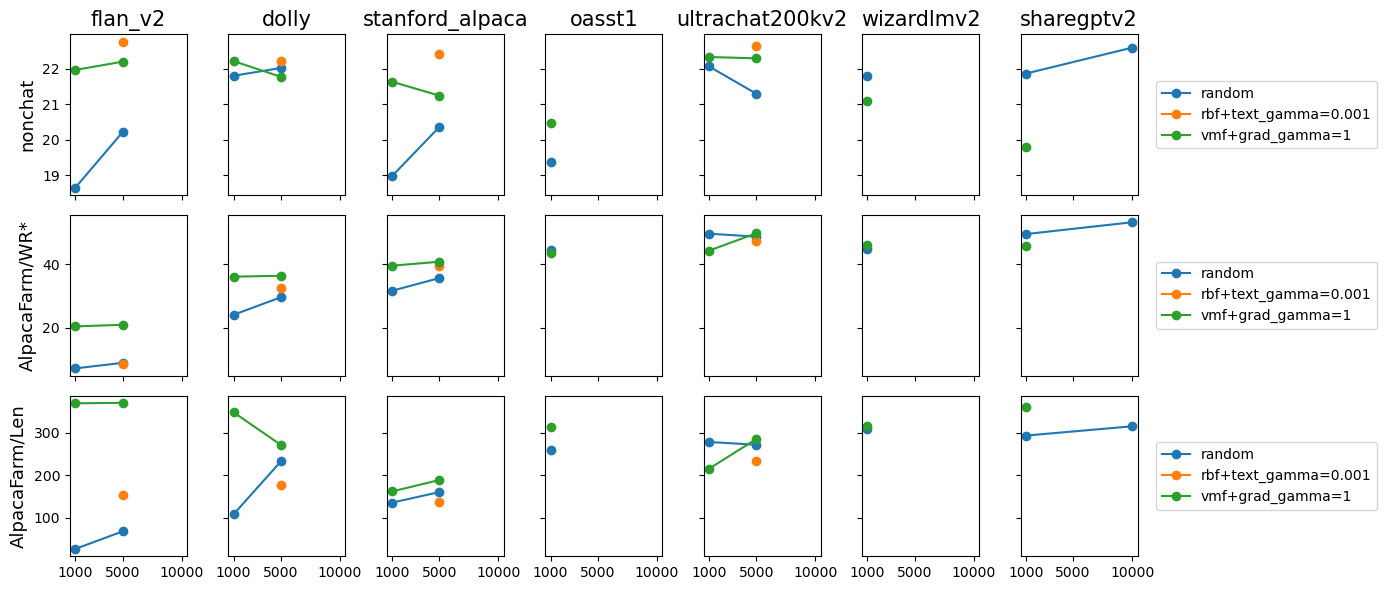

In [70]:

import matplotlib.pyplot as plt

yaxis_type = 'abs'
assert(yaxis_type in ['delta_random', 'abs'])
datasets = ['flan_v2', 'dolly', 'stanford_alpaca', 'oasst1', 'ultrachat200kv2', 'wizardlmv2', 'sharegptv2']
task_names = ['MMLU/0-shot', 'GSM/CoT', 'BBH/Direct', 'TydiQA/GP', 'Codex-Eval/Pass@1', 'AlpacaFarm/WR*',]
task_names = ['nonchat', 'AlpacaFarm/WR*', 'AlpacaFarm/Len',]
# task_names = ['AlpacaFarm/WR*',]


ncols = len(datasets)
nrows = len(task_names)
fig, axs = plt.subplots(nrows, ncols, figsize=(2*ncols,2*nrows), sharey='row', sharex=True)

xs_possible = []

for axi, task_name in enumerate(task_names):
    d = D[task_name]
    for axj, dataset in enumerate(datasets):
        ax = axs.reshape(nrows, ncols)[axi, axj]
        sort_by_types = sorted(set(x.sort_by_type for x in d.keys()))

        for i, sort_by_type in enumerate(sort_by_types):
            xs = sorted([x.subset_size for x in d.keys()
                         if x.dataset == dataset and x.sort_by_type==sort_by_type])
            xs_possible += list(set(xs) - set(xs_possible))
            ys = [d[DKey(sort_by_type, dataset, x)] for x in xs]
            if yaxis_type == 'delta_random':
                ys = [y-d[DKey('vmf+grad+gamma=1', dataset, x)] for x, y in zip(xs, ys)] 
            ax.plot(xs, ys, 'o-', label=sort_by_type)
        
#         ax.set_yscale('log')
            
for axi, task_name in enumerate(task_names):
    axs.reshape(nrows, ncols)[axi, 0].set_ylabel('△ '+task_name if yaxis_type.startswith('delta') else task_name, fontsize=13)
    axs.reshape(nrows, ncols)[axi, -1].legend(loc='center left', bbox_to_anchor=(1.1, 0.5))
for axj, dataset in enumerate(datasets):
    axs.reshape(nrows, ncols)[0, axj].set_title(dataset, fontsize=15)
    axs.reshape(nrows, ncols)[0, axj].set_xticks(xs_possible, xs_possible)

space = 0.05
fig.subplots_adjust(wspace=space, hspace=space)  # Adjust the value as needed

fig.tight_layout()

In [18]:
xs = np.array([1_000, 5_000, 10_000, 20_000, 40_000])
xs/50_000

array([0.02, 0.1 , 0.2 , 0.4 , 0.8 ])